In [27]:
import itertools
import math
import os
import gsd.hoomd
import hoomd
import numpy
import warnings
import fresnel
import IPython
import packaging.version 
import matplotlib
import io 
import PIL
import freud
import matplotlib.pyplot as plt

%matplotlib inline 
matplotlib.style.use('ggplot')
import matplotlib_inline

matplotlib_inline.backend_inline.set_matplotlib_formats('svg')


In [28]:
device = fresnel.Device()
tracer = fresnel.tracer.Path(device=device, w=300, h=300)

def render(snapshot):

    L = snapshot.configuration.box[0]
    scene = fresnel.Scene(device)
    geometry = fresnel.geometry.Sphere(
        scene, N=len(snapshot.particles.position), radius=1
    )
    geometry.material = fresnel.material.Material(
        color=fresnel.color.linear([252 / 255, 209 / 255, 1 / 255]), roughness=0.5
    )
    geometry.position[:] = snapshot.particles.position[:]
    geometry.outline_width = 0.04
    fresnel.geometry.Box(scene, [L, L, L, 0, 0, 0], box_radius=0.02)

    scene.lights = [
        fresnel.light.Light(direction=(0, 0, 1), color=(0.8, 0.8, 0.8), theta=math.pi),
        fresnel.light.Light(
            direction=(1, 1, 1), color=(1.1, 1.1, 1.1), theta=math.pi / 3
        ),
    ]
    scene.camera = fresnel.camera.Orthographic(
        position=(L * 2, L, L * 2), look_at=(0, 0, 0), up=(0, 1, 0), height=L * 1.4 + 1
    )
    scene.background_alpha = 1
    scene.background_color = (1, 1, 1)
    return IPython.display.Image(tracer.sample(scene, samples=500)._repr_png_())

In [29]:
cpu = hoomd.device.CPU()
simulation = hoomd.Simulation(device=cpu, seed=17)
simulation.create_state_from_gsd(filename='trajectory_expansion.gsd')

In [30]:
mc = hoomd.hpmc.integrate.Sphere(default_d=1, default_a=0)
mc.shape["A"] = dict(diameter=2)
simulation.operations.integrator = mc
print('diameter = ', mc.shape["A"]["diameter"])

diameter =  2.0


In [31]:
tune = hoomd.hpmc.tune.MoveSize.scale_solver(
    moves=['d'],
    target=0.2,
    max_translation_move=1,
    trigger=hoomd.trigger.And(
        [hoomd.trigger.Periodic(100), hoomd.trigger.Before(simulation.timestep + 5000)]
    ),
)
simulation.operations.tuners.append(tune)

In [32]:
import hoomd
import hoomd.hpmc
import math
import matplotlib.pyplot as plt
import numpy as np
import freud
import gsd

# Store results: Overlaps, volume fractions, and solid-like particle counts
volume_fractions = []
overlaps_list = []
all_solid_counts = {}  # Dictionary to store solid counts for each volume fraction

# Function to run a single simulation and save trajectory to GSD file
def run_simulation_for_vf(target_volume_fraction):
    volume_particle = (4 / 3) * math.pi * (1**3)  # Volume of a single particle
    target_rho = target_volume_fraction / volume_particle  # Target density

    final_rho = target_rho
    final_volume = simulation.state.N_particles / final_rho  # Calculate final volume

    inverse_volume_ramp = hoomd.variant.box.InverseVolumeRamp(
        initial_box=simulation.state.box,
        final_volume=final_volume,
        t_start=simulation.timestep,
        t_ramp=20_000,
    )

    # Set up box resize updater and run simulation
    box_resize = hoomd.update.BoxResize(
        trigger=hoomd.trigger.Periodic(10),
        box=inverse_volume_ramp,
    )
    simulation.operations.updaters.append(box_resize)

    # Create a GSD file to store trajectory for this volume fraction
    gsd_filename = f'trajectory_vf_{target_volume_fraction:.2f}.gsd'
    gsd_writer = hoomd.write.GSD(filename=gsd_filename,
                                 trigger=hoomd.trigger.Periodic(100),
                                 mode='wb',
                                 filter=hoomd.filter.All())
    simulation.operations.writers.append(gsd_writer)

    # Run the simulation
    simulation.run(20001)

    # Get and store the number of overlaps
    overlaps = mc.overlaps
    volume_fractions.append(target_volume_fraction)
    overlaps_list.append(overlaps)
    print(f"Volume Fraction: {target_volume_fraction}, Overlaps: {overlaps}")

    # Flush the trajectory to ensure all frames are saved
    gsd_writer.flush()

    # Analyze solid-like particles for each frame in this GSD file
    solid = freud.order.SolidLiquid(l=6, q_threshold=0.7, solid_threshold=6)
    solid_counts = []

    traj_cmp = gsd.hoomd.open(gsd_filename)
    for frame in traj_cmp:
        solid.compute(
            system=(frame.configuration.box, frame.particles.position),
            neighbors=dict(mode='nearest', num_neighbors=12),
        )
        num_solid_particles = np.sum(solid.num_connections > solid.solid_threshold)
        solid_counts.append(num_solid_particles)

    # Store solid counts for this volume fraction
    all_solid_counts[target_volume_fraction] = solid_counts
    print(f"Volume Fraction: {target_volume_fraction}, Solid Counts per Frame: {solid_counts}")

# Run simulations for volume fractions from 0.45 to 0.74 (in increments of 0.01)
for vf in np.arange(0.55, 0.74, 0.01):
    run_simulation_for_vf(vf)

# Plot the number of overlaps vs volume fraction
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(volume_fractions, overlaps_list, marker='o', label='Overlaps')
ax.set_xlabel('Volume Fraction')
ax.set_ylabel('Number of Overlaps')
ax.set_title('Overlaps vs Volume Fraction')
ax.legend()
plt.show()

# Plot solid-like particle counts for each volume fraction
fig, ax = plt.subplots(figsize=(8, 6))
for vf, solid_counts in all_solid_counts.items():
    ax.plot(solid_counts, label=f'VF={vf:.2f}')

ax.set_xlabel('Frame')
ax.set_ylabel('Number of Solid Particles')
ax.set_title('Solid Particles per Frame for Different Volume Fractions')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Volume Fraction: 0.55, Overlaps: 15
Volume Fraction: 0.55, Solid Counts per Frame: [np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int

KeyboardInterrupt: 

In [8]:
device = fresnel.Device()
tracer = fresnel.tracer.Path(device=device, w=300, h=300)

def render(snapshot, particles=None, is_solid=None):

    N = snapshot.particles.N
    L = snapshot.configuration.box[0]
    if particles is not None:
        N = len(particles)
    if is_solid is not None:
        N = int(numpy.sum(is_solid))

    scene = fresnel.Scene(device)
    geometry = fresnel.geometry.Sphere(
        scene, N=len(snapshot.particles.position), radius=1
    )
    geometry.material = fresnel.material.Material(
        color=fresnel.color.linear([252 / 255, 209 / 255, 1 / 255]), roughness=0.5
    )
    if particles is None and is_solid is None:
        geometry.position[:] = snapshot.particles.position[:]
        
    elif particles is not None:
        geometry.position[:] = snapshot.particles.position[particles, :]
        
    elif is_solid is not None:
        geometry.position[:] = snapshot.particles.position[
            numpy.ix_(is_solid, [0, 1, 2])
        ]

    geometry.outline_width = 0.04
    fresnel.geometry.Box(scene, [L, L, L, 0, 0, 0], box_radius=0.02)

    scene.lights = [
        fresnel.light.Light(direction=(0, 0, 1), color=(0.8, 0.8, 0.8), theta=math.pi),
        fresnel.light.Light(
            direction=(1, 1, 1), color=(1.1, 1.1, 1.1), theta=math.pi / 3
        ),
    ]
    scene.camera = fresnel.camera.Orthographic(
        position=(L * 2, L, L * 2), look_at=(0, 0, 0), up=(0, 1, 0), height=L * 1.4 + 1
    )
    scene.background_alpha = 1
    scene.background_color = (1, 1, 1)
    return tracer.sample(scene, samples=500)

def render_movie(frames, particles=None, is_solid=None):
    if is_solid is None:
        is_solid = [None] * len(frames)
    a = render(frames[0], particles, is_solid[0])

    im0 = PIL.Image.fromarray(a[:, :, 0:3], mode='RGB').convert(
        'P', palette=PIL.Image.Palette.ADAPTIVE
    )
    ims = []
    for i, f in enumerate(frames[1:]):
        a = render(f, particles, is_solid[i])
        im = PIL.Image.fromarray(a[:, :, 0:3], mode='RGB')
        im_p = im.quantize(palette=im0)
        ims.append(im_p)

    blank = numpy.ones(shape=(im.height, im.width, 3), dtype=numpy.uint8) * 255
    im = PIL.Image.fromarray(blank, mode='RGB')
    im_p = im.quantize(palette=im0)
    ims.append(im_p)

    f = io.BytesIO()
    im0.save(f, 'gif', save_all=True, append_images=ims, duration=1000, loop=0)

    size = len(f.getbuffer()) / 1024
    if size > 3000:
        warnings.warn(f'Large GIF: {size} KiB')
    return IPython.display.display(IPython.display.Image(data=f.getvalue()))

In [10]:
traj_cmp = gsd.hoomd.open('trajectory_vf_0.56.gsd')
len(traj_cmp)

200

In [11]:
solid = freud.order.SolidLiquid(l=6, q_threshold=0.7, solid_threshold=6)
is_solid = []
for frame in traj_cmp:
    solid.compute(
        system=(frame.configuration.box, frame.particles.position),
        neighbors=dict(mode='nearest', num_neighbors=12),
    )
    is_solid.append(solid.num_connections > solid.solid_threshold)

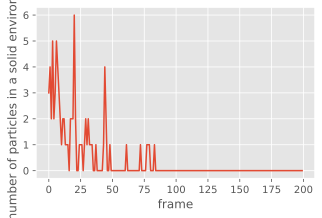

In [12]:
fig = matplotlib.figure.Figure(figsize=(5, 3.09))
ax = fig.add_subplot()
num_solid = numpy.array([numpy.sum(a) for a in is_solid])
ax.plot(num_solid)
ax.set_xlabel('frame')
ax.set_ylabel('number of particles in a solid environment')
fig

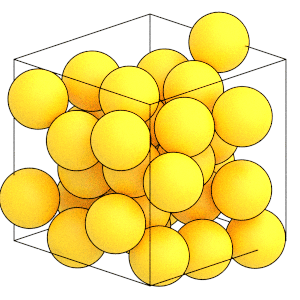

In [13]:
render_movie(traj_cmp[0:100:12])